/Users/marael/work/gdc-jupyter/templates/setup.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_interpolate[dim_y] = data_interpolate[dim_y].interpolate(method='linear')


Test error (mse): 8.371120332441858


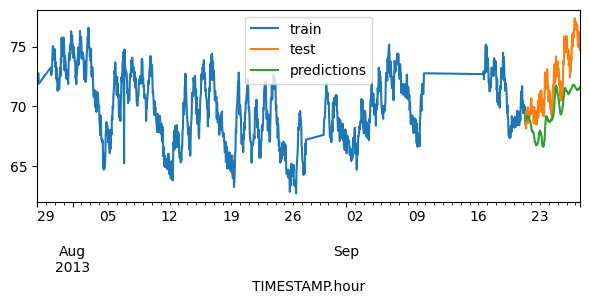

In [1]:
from setup import *

# notebook input from an insight
sample = InsightEnvironment(insight_id="657f0cc8-fa05-46bb-9808-8cf4f065ce3d")
pred = predict(sample)

In [2]:
print(pred)

{'pred': {Timestamp('2013-07-28 00:00:00', freq='H'): nan, Timestamp('2013-07-28 01:00:00', freq='H'): nan, Timestamp('2013-07-28 02:00:00', freq='H'): nan, Timestamp('2013-07-28 03:00:00', freq='H'): nan, Timestamp('2013-07-28 04:00:00', freq='H'): nan, Timestamp('2013-07-28 05:00:00', freq='H'): nan, Timestamp('2013-07-28 06:00:00', freq='H'): nan, Timestamp('2013-07-28 07:00:00', freq='H'): nan, Timestamp('2013-07-28 08:00:00', freq='H'): nan, Timestamp('2013-07-28 09:00:00', freq='H'): nan, Timestamp('2013-07-28 10:00:00', freq='H'): nan, Timestamp('2013-07-28 11:00:00', freq='H'): nan, Timestamp('2013-07-28 12:00:00', freq='H'): nan, Timestamp('2013-07-28 13:00:00', freq='H'): nan, Timestamp('2013-07-28 14:00:00', freq='H'): nan, Timestamp('2013-07-28 15:00:00', freq='H'): nan, Timestamp('2013-07-28 16:00:00', freq='H'): nan, Timestamp('2013-07-28 17:00:00', freq='H'): nan, Timestamp('2013-07-28 18:00:00', freq='H'): nan, Timestamp('2013-07-28 19:00:00', freq='H'): nan, Timestamp(